# Predict hotel bookings via user behaviour

The main objective of this assignment is how do we deal with the dataset when target is very skewed. There are many real life scenarios where we face this situation like 

* Fault in assembly line production.
* Credit card fraud detection
* Cancer detection where most of the samples are benign, etc.

This dataset is also an example of skewed target. 

In this exercise, I will be focussing more on how to deal with skewness rather than hyper paramter tuning, grid search, ensemble modeling.

## 1.) Let's load the data first and do a preliminary analysis

In [175]:
#Load libraries

#Essentials
import pandas as pd
import numpy as np

#Warnings
import warnings
warnings.filterwarnings('ignore')

#Garbage Collection
import gc

#Display Images
from IPython.display import Image

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#metrics and cross validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score,StratifiedKFold

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier


There are two data files. 

   **Booking (case_study_bookings_train)** : List of sessions, each with: session-related contextual data, and whether at least one booking was made.
   
   **User Actions (case_study_actions_train)** : Sequence of various type of user actions generated during the usage of the website.


In [176]:
#Let us load the data files.

train_data_booking = pd.read_csv("../input/case_study_bookings_train.csv", sep=r'\t')
train_data_actions = pd.read_csv("../input/case_study_actions_train.csv", sep=r'\t')

- **Columns:**


	- ymd: Date of the session in format 'yyMMdd'
	- user_id: Anonymized cookie id of the visitor
	- session_id: Anonymized id of the session
    - action_id: Type of the action
    - reference: Object of the action. - We note that action_ids with big set of reference values (e.g. action id '2116') are typically related to the content (e.g hotels, destinations or keywords); while action_ids with small reference set (e.g. action id '2351') are more related a function of the website (e.g. sorting order, room type, filters, etc.)
    - step: The number identifying the action in the session
	- referer_code: Encoded category of the referer to the website
	- is_app: If the session was made using the trivago app
	- agent_id: Encoded type of the browser
	- traffic_type: A categorization of the type of the traffic
	- has_booking: 1 if at least one booking was made during the session (excluded from the target set)

In [177]:
#Function to siplay full data instead of ellipses (...)
#This help in checking the data through naked eyes if you want to check more rows.

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [178]:
display_all(train_data_booking.head(10))

,ymd,user_id,session_id,referer_code,is_app,agent_id,traffic_type,has_booking
0,20170423,388309106223940,3052767322364990735,0,0,2,1,0
1,20170410,452426828488840,1022778951418899936,0,0,10,2,0
2,20170415,452426828488840,4191504489082712531,0,0,10,2,0
3,20170406,819438352219100,4560227804862289210,1,0,1,1,0
4,20170407,1113732603712480,4115013282086590434,0,0,9,2,0
5,20170419,1607565913119260,5462519157199531712,1,0,14,1,0
6,20170416,1799104857432640,6192546532479759064,99,0,1,6,0
7,20170417,2193000336357140,218841333828334811,99,0,1,6,0
8,20170416,2413031573758500,6317573206950631304,1,0,2,2,0
9,20170404,2427966799998760,1055322285624855013,99,0,7,6,0


In [179]:
display_all(train_data_actions.head(10))

,ymd,user_id,session_id,action_id,reference,step
0,20170423,388309106223940,3052767322364990735,8001,1323836,1
1,20170410,452426828488840,1022778951418899936,2116,929835,1
2,20170410,452426828488840,1022778951418899936,6999,0,2
3,20170410,452426828488840,1022778951418899936,2116,929835,3
4,20170410,452426828488840,1022778951418899936,2503,1,4
5,20170410,452426828488840,1022778951418899936,8001,929835,5
6,20170415,452426828488840,4191504489082712531,2113,447485,1
7,20170415,452426828488840,4191504489082712531,6999,0,2
8,20170415,452426828488840,4191504489082712531,2113,447485,3
9,20170406,819438352219100,4560227804862289210,2100,0,1


In [180]:
print(train_data_booking.shape, train_data_actions.shape)

(307677, 8) (5862863, 6)


In [181]:
print(train_data_booking.session_id.nunique(), train_data_actions.session_id.nunique())

307677 306106


In [182]:
#Let's check for missing values.
def check_missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    missing_data =pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [183]:
print(check_missing_data(train_data_booking))
print(check_missing_data(train_data_actions))

              Total  Percent
has_booking       0      0.0
traffic_type      0      0.0
agent_id          0      0.0
is_app            0      0.0
referer_code      0      0.0
session_id        0      0.0
user_id           0      0.0
ymd               0      0.0
            Total  Percent
step            0      0.0
reference       0      0.0
action_id       0      0.0
session_id      0      0.0
user_id         0      0.0
ymd             0      0.0


We need to merge data as this is parent child relationship.

### Feature Engineering on action data

In [184]:
#Get distinct counts for all the variables for session id

train_data_actions = train_data_actions.groupby(["session_id",
                                                "user_id",
                                                "ymd"], as_index=False).agg({"action_id": lambda x: x.nunique(),
                                                                             "reference": lambda x: x.nunique(),
                                                                             "step": lambda x: x.nunique()})

In [185]:
display_all(train_data_actions.head())

,session_id,user_id,ymd,action_id,reference,step
0,109716089376632,1155091784087964071,20170424,4,4,5
1,200020048406165,3097723837883077089,20170427,3,2,4
2,245254191257007,8695058068547645906,20170421,4,5,6
3,277983337698624,3411637331844700331,20170416,7,10,15
4,337473025323913,3083786443353947941,20170403,2,2,4


In [186]:
train_data = pd.merge(train_data_actions, train_data_booking,   
                      how='outer', left_on=['ymd','user_id', 'session_id'], right_on = ['ymd','user_id', 'session_id'])

print(check_missing_data(train_data))

train_data = train_data.fillna(train_data.median())

print(check_missing_data(train_data))
print(train_data.shape)

              Total  Percent
step           1571   0.5106
reference      1571   0.5106
action_id      1571   0.5106
has_booking       0   0.0000
traffic_type      0   0.0000
agent_id          0   0.0000
is_app            0   0.0000
referer_code      0   0.0000
ymd               0   0.0000
user_id           0   0.0000
session_id        0   0.0000
              Total  Percent
has_booking       0      0.0
traffic_type      0      0.0
agent_id          0      0.0
is_app            0      0.0
referer_code      0      0.0
step              0      0.0
reference         0      0.0
action_id         0      0.0
ymd               0      0.0
user_id           0      0.0
session_id        0      0.0
(307677, 11)


Since only 0.5 % of whole data is missing because of join, I will fill it with median.

## If we look closely first 10 rows of train_data_booking, has_booking is always zero. This suggests us target value might be imbalanced. This is the catch.

Class 0: 288030
Class 1: 19647
Proportion: 14.66 : 1


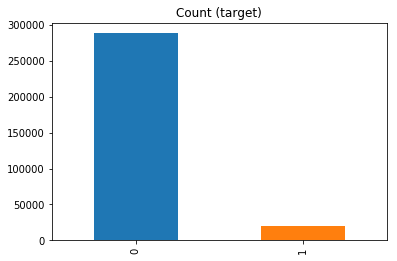

In [187]:
#So, let's quickly check the skewness of target variable. Is it highly skewed?

target_count = train_data_booking.has_booking.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

As suspected, it is highly skewed. Most of the rows corresponds to no-booking.

One of the issues that we can fell into when working with imbalanced data sets is to use wrong metric to evaluate the model. Using simpler metrics like **accuracy_score** can lead to high accuracy even if classifier predicts everything as in most common class. We have high accuracy but only as an illusion.

In [188]:
#Drop user_id and session_id from the data as they are unique identifers only.

train_data.drop(labels=['user_id','session_id'], axis = 1, inplace=True)

In [189]:
labels = train_data.columns[:8]
print(labels)
X = train_data[labels]
y = train_data['has_booking']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Index(['ymd', 'action_id', 'reference', 'step', 'referer_code', 'is_app',
       'agent_id', 'traffic_type'],
      dtype='object')
(246141, 8) (61536, 8) (246141,) (61536,)


In [190]:
model = RandomForestClassifier(random_state = 42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 92.43%


Let us train the model only using one feature which is least important. This should reduce the accuracy drastically, right?

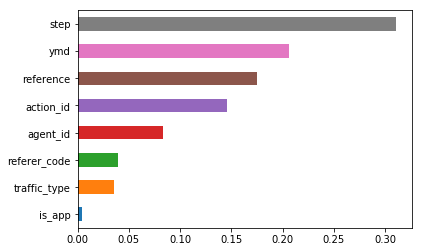

In [191]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nsmallest(10).plot(kind='barh')

In [192]:
model = RandomForestClassifier(random_state = 42)
model.fit(X_train[['is_app']], y_train)
y_pred = model.predict(X_test[['is_app']])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.45%


We noticed that accuracy has not dropped even though we are predicting only on one variable and that too the least important as per Random Forest. This is because, if most of the predictors falls under the majority category, we will have high accuracy even if minority category is not well qualified. This means this is not the correct metric to score.

## Confusion Matrix

An interesting way to evaluate the results is by the means of confusion matrix, which shows the correct and incorrect predictions for each class. In the first row, the first column indicates how many classes 0 were predicted correctly, and the second column, how many classes 0 were predicted as 1. In the second row, we note that allmost all the class 1 entries were erroneously predicted as class 0.

Therefore, the higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

Confusion matrix:
 [[57508     0]
 [ 4028     0]]


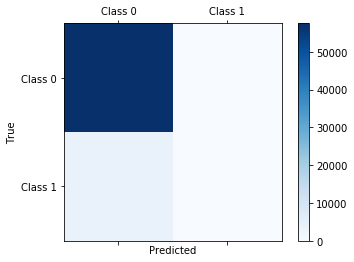

In [193]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [194]:
y_test.value_counts()

0    57508
1     4028
Name: has_booking, dtype: int64

Even though we have an accuracy of 93.45% We can see that out of **4028** samples where there is a booking, we have all of them misclassified.

To remove skewness of the target variable, we will use a technique called sampling.

It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

<img src="https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png">

## Under-sampling

In the following steps, we are doing undersampling the majority class and then fitting the RandomForestClassifier on undersampled data.

Once fit, we will predict both on undersampled data and our full validation set.

In [195]:
#Find number of samples for booking.
booking_yes = len(train_data[train_data['has_booking'] == 1])

In [196]:
#Get indices of non booking samples
booking_no_indices = train_data[train_data.has_booking == 0].index

In [197]:
#Random sample non booking indices
random_indices = np.random.choice(booking_no_indices,booking_yes, replace=False)

In [198]:
#Find the indices of booking samples
booking_yes_indices = train_data[train_data.has_booking == 1].index

In [199]:
#Concat booking indices with sample non-booking ones
under_sample_indices = np.concatenate([booking_yes_indices,random_indices])

In [200]:
#Get Balance Dataframe
under_sample = train_data.loc[under_sample_indices]

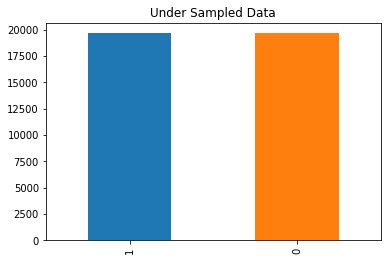

In [201]:
under_sample.has_booking.value_counts().plot(kind='bar', title='Under Sampled Data')

Now we have undersampled data. We will fit our model on this data and then predict on both undersample validation set and full validation set.

In [202]:
X_under = under_sample.loc[:,under_sample.columns != 'has_booking']
y_under = under_sample.loc[:,under_sample.columns == 'has_booking']
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under,y_under,
                                                                            test_size = 0.3, random_state = 42)

rf_under = RandomForestClassifier(n_estimators=20,random_state = 42)
rf_under.fit(X_under_train,y_under_train)
y_under_pred = rf_under.predict(X_under_test)

In [203]:
#For undersampled set of data

from sklearn.metrics import recall_score, accuracy_score
print(recall_score(y_under_test,y_under_pred))
print(accuracy_score(y_under_test,y_under_pred))

0.7577565632458234
0.7119348545254051


In [204]:
#Check recall and accuracy For full Data set.

y_pred_full_us =  rf_under.predict(X_test)
print(y_pred_full_us.shape)
print(recall_score(y_test,y_pred_full_us))
print(accuracy_score(y_test,y_pred_full_us))

(61536,)
0.9024329692154915
0.6981279251170047


As discussed earlier, Recall and accuracy are not the correct judges for this type of skewed dataset. So let's check our new confusion matrix based on undersampled data.

Confusion matrix:
 [[39325 18183]
 [  393  3635]]


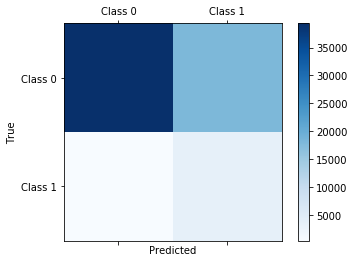

In [205]:
#Create a Confusion Matrix.

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_full_us)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

A simple undersampling of data provides much better results.

We can see that outof **3928** samples where there is a booking, we have now only **371 missclassified** and  **3657 rightly classified**. 

### But undersampling is causing many of the non booking samples to be classified as booking samples.

Let us try over sampling using SMOTE

## Over-Sampling

In [206]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [207]:
rf_over = RandomForestClassifier(n_estimators=20, random_state=12)
rf_over.fit(x_train_res, y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

Confusion matrix:
 [[55957  1551]
 [ 3624   404]]


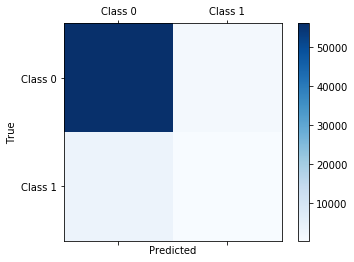

In [208]:
#Create a Confusion Matrix.

y_pred_full_os =  rf_over.predict(X_test)

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_full_os)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## As our evaluation metric is Matthew correlation coefficient, we will use that and see what do we get.

1 is perfect prediction, 0 is mean prediction and -1 is exact opposite prediction.

In [209]:
from sklearn.metrics import matthews_corrcoef


print("Under Sampling MCC")
print("--------------")
print(matthews_corrcoef(y_test, y_pred_full_us))
print("Over Sampling MCC")
print("--------------")
print(matthews_corrcoef(y_test, y_pred_full_os))


Under Sampling MCC
--------------
0.3031036811413834
Over Sampling MCC
--------------
0.10340700757351574


Undersampling is giving better results.

## Can we do better? 

Since in this competition, we can submit multiple entries with better prediction, I will be submitting another version. 

For now, let's predict on test data and submit predictions.

In [210]:
#Load test data.

test_data_booking = pd.read_csv("../input/case_study_bookings_target.csv", sep=r'\t')
test_data_action = pd.read_csv("../input/case_study_actions_target.csv", sep=r'\t')

In [211]:
test_data_booking.head()

,ymd,user_id,session_id,referer_code,is_app,agent_id,traffic_type
0,20170430,1607565913119260,4175939893794521966,0,0,14,6
1,20170430,1607565913119260,9175174925268392332,0,0,14,1
2,20170430,2669945826129900,5361965966177226983,0,0,6,6
3,20170430,6247954936827660,7996347049132178025,0,0,13,2
4,20170430,6447705595982360,6061498713259551906,99,0,1,6


In [212]:
test_data_action.head()

,ymd,user_id,session_id,action_id,reference,step
0,20170430,1607565913119260,4175939893794521966,2113,60196,1
1,20170430,1607565913119260,4175939893794521966,6999,0,2
2,20170430,1607565913119260,4175939893794521966,2113,60196,3
3,20170430,1607565913119260,9175174925268392332,2100,0,1
4,20170430,1607565913119260,9175174925268392332,6999,0,2


In [213]:
#Get distinct counts for all the variables for session id

test_data_action = test_data_action.groupby(["session_id",
                                                "user_id",
                                                "ymd"], as_index=False).agg({"action_id": lambda x: x.nunique(),
                                                                             "reference": lambda x: x.nunique(),
                                                                             "step": lambda x: x.nunique()})

In [214]:
test_data = pd.merge(test_data_action, test_data_booking,  
                      how='right', left_on=['ymd','user_id', 'session_id'], right_on = ['ymd','user_id', 'session_id'])

print(test_data_booking.shape, test_data_action.shape, test_data.shape)

(30128, 7) (29957, 6) (30128, 10)


In [215]:
test_data.head()

,session_id,user_id,ymd,action_id,reference,step,referer_code,is_app,agent_id,traffic_type
0,288684655403597,6670497003774730124,20170430,9.0,10.0,26.0,1,0,8,2
1,2068710939824077,6071651557517368562,20170428,2.0,2.0,3.0,99,0,1,6
2,2298782344372930,2411734458470049340,20170429,4.0,4.0,5.0,99,0,1,6
3,2357002303902869,6856319856186660245,20170429,6.0,6.0,11.0,99,0,6,2
4,2696151572174766,7126384637664875906,20170430,1.0,1.0,1.0,0,1,9,1


In [216]:
#Replace NaN with median and remove session and userid
test_data = test_data.fillna(test_data.median())
test_data.drop(labels=['user_id','session_id'], axis = 1, inplace=True)

In [217]:
submission = pd.DataFrame()
submission['session_id'] = test_data_booking.session_id
submission['has_booking'] = rf_under.predict(test_data)

In [218]:
display_all(submission.head(10))
print(submission.shape)

,session_id,has_booking
0,4175939893794521966,1
1,9175174925268392332,0
2,5361965966177226983,0
3,7996347049132178025,1
4,6061498713259551906,0
5,517603758164921943,0
6,2495268472746631452,1
7,3462607902786480031,1
8,8327507071219915101,1
9,7317759385154836928,1


(30128, 2)


In [219]:
submission.to_csv("Predict Hotel_Booking.csv")

Class 0: 19995
Class 1: 10133
Proportion: 1.97 : 1


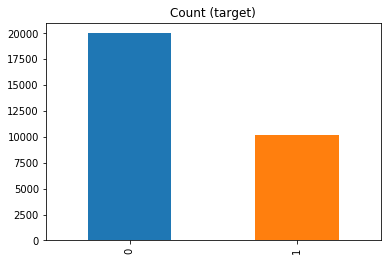

In [220]:
target_count = submission.has_booking.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

# Iteration 2

In [221]:
print(train_data.shape, test_data.shape)

(307677, 9) (30128, 8)


## Test Multiple classifiers. - Iteration 2

In [222]:
y_train = train_data["has_booking"]
X_train = train_data.drop(labels=["has_booking"], axis =1)

In [223]:
kfold = StratifiedKFold(n_splits=10)

In [224]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

random_state = 42
classifiers = []
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))

cv_results = []

for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y_train, scoring="accuracy", cv = kfold, n_jobs=-1))
    
cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans": cv_means, "CrossValErrors": cv_std, 
                       "Algorithm": ["RandomForestClassifier", "Extra Trees" ,"Gradient Boosting"]})

cv_res = cv_res.sort_values(by = "CrossValMeans", ascending=False)
cv_res

,CrossValMeans,CrossValErrors,Algorithm
2,0.936134,0.000032,Gradient Boosting
0,0.925344,0.000894,RandomForestClassifier
1,0.920729,0.001094,Extra Trees


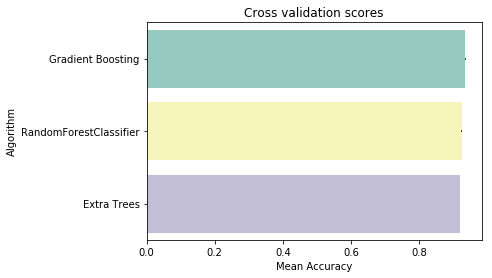

In [225]:
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

Let's work with three algorithms

* Gradient Boost
* Extra trees, and
* RandomForest

In [226]:
X_under = under_sample.loc[:,under_sample.columns != 'has_booking']
y_under = under_sample.loc[:,under_sample.columns == 'has_booking']
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under,y_under,
                                                                            test_size = 0.3, random_state = 42)


#GradientBoostingClassifier
gr_under = GradientBoostingClassifier(n_estimators=20, random_state = 42)
gr_under.fit(X_under_train,y_under_train)
y_under_pred_gr = gr_under.predict(X_under_test)

#Random Forest
rf_under = RandomForestClassifier(n_estimators=20,random_state = 42)
rf_under.fit(X_under_train,y_under_train)
y_under_pred_rf = rf_under.predict(X_under_test)

#Extra tree
et_under = ExtraTreesClassifier(n_estimators=20,random_state = 42)
et_under.fit(X_under_train,y_under_train)
y_under_pred_et = et_under.predict(X_under_test)

In [227]:
#Confusion Matrix

def conf_matrix(models):
    for model in models:
        y_pred_full =  model.predict(X_test)
        conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_full)
        print(model)
        print("---------")
        print('Confusion matrix:\n', conf_mat)

In [228]:
conf_matrix({gr_under, rf_under, et_under})

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
---------
Confusion matrix:
 [[39325 18183]
 [  393  3635]]
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
---------
Confusion matrix:
 [[39436 18072]
 [  417  3611]]
GradientBoostingClassifier(criterion='friedman_mse', init=None,
  

Extra tress is classifying booking better, but it is misclassifying non-bookings worse than Random Forest. We need to check, which one gives better Mathew corelation coefficient.

In [229]:
def mathew_corr(models):
    for model in models: 
        y_pred_full =  model.predict(X_test)
        print(model)
        print("-------------")
        print(matthews_corrcoef(y_test, y_pred_full))
    

mathew_corr({rf_under,et_under,gr_under})

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
-------------
0.3031036811413834
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
-------------
0.3014448284285129
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_de

In [234]:
#Let us load the data files.

train_data_booking = pd.read_csv("../input/case_study_bookings_train.csv", sep=r'\t')
train_data_actions = pd.read_csv("../input/case_study_actions_train.csv", sep=r'\t')

In [235]:
train_data_check = pd.merge(train_data_actions, train_data_booking,   
                      how='outer', left_on=['ymd','user_id', 'session_id'], right_on = ['ymd','user_id', 'session_id'])

In [262]:
display_all(train_data_check.action_id.value_counts().head(10))

2142.0    1150642
2113.0     689437
8001.0     343534
2116.0     278855
6999.0     253549
2111.0     180022
2371.0     156456
2119.0     145060
2358.0     138146
2503.0     135171
Name: action_id, dtype: int64

In [263]:
display_all(train_data_check.groupby(['action_id', 'has_booking']).agg({"has_booking": lambda x: x.count()}).sort_values('has_booking', ascending =False).head(10))

,,has_booking
action_id,has_booking,
2142.0,0,977569
2113.0,0,613847
8001.0,0,278575
2116.0,0,257001
6999.0,0,237191
2142.0,1,173073
2111.0,0,169148
2503.0,0,126617
2119.0,0,122871


In [264]:
display_all(train_data_check[(train_data_check["action_id"] == 2142.0) & (train_data_check["has_booking"] == 1)].head(100))

,ymd,user_id,session_id,action_id,reference,step,referer_code,is_app,agent_id,traffic_type,has_booking
634,20170427,4363237848805940,7436658240590183808,2142.0,552751.0,238.0,1,0,1,2,1
855,20170413,7191023491428400,415844907394554878,2142.0,386461.0,9.0,1,0,1,3,1
856,20170413,7191023491428400,415844907394554878,2142.0,386461.0,10.0,1,0,1,3,1
857,20170413,7191023491428400,415844907394554878,2142.0,386461.0,11.0,1,0,1,3,1
870,20170413,7191023491428400,6392194623261278838,2142.0,386461.0,10.0,1,0,1,2,1
871,20170413,7191023491428400,6392194623261278838,2142.0,386461.0,11.0,1,0,1,2,1
872,20170413,7191023491428400,6392194623261278838,2142.0,386461.0,12.0,1,0,1,2,1
875,20170413,7191023491428400,6392194623261278838,2142.0,48140.0,16.0,1,0,1,2,1
1151,20170414,9263534596709119,8166323123425424328,2142.0,12399.0,4.0,0,0,9,2,1
1163,20170414,9263534596709119,8166323123425424328,2142.0,12438.0,16.0,0,0,9,2,1
